In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib as mpl
from datetime import datetime
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping
mpl.rcParams['figure.figsize'] = (20, 15)
mpl.rcParams['axes.grid'] = False
import tensorflow as tf 
np.random.seed(42)
tf.random.set_seed(42)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
ls'/content/gdrive/My Drive/Thesis'

dataframe_dma_flow_1D.csv       dataframe_flow_variable_60min.csv
dataframe_dma_flow_60min.csv    DMA_225.csv
dataframe_flow_1D.csv           DMA_468.csv
dataframe_flow_variable_1D.csv  persistence_results.pkl


In [4]:
data = pd.read_csv("/content/gdrive/My Drive/Thesis/dataframe_flow_variable_60min.csv")
data['Unnamed: 0'] = pd.to_datetime(data['Unnamed: 0'])
data.rename( columns={'Unnamed: 0':'Date_time','468':'DMA_468'}, inplace=True )

In [5]:
data_DMA468 = data[['Date_time','DMA_468','tempC','HeatIndexC','FeelsLikeC','WindChillC','windspeedKmph','sunHour','precipMM','humidity']]
data_DMA468.shape

(2208, 10)

<Figure size 1440x1440 with 0 Axes>

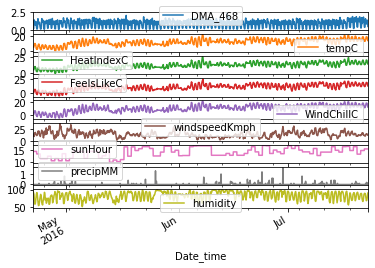

<Figure size 1440x1440 with 0 Axes>

In [6]:
data_DMA468_indexed = data_DMA468.set_index('Date_time')
data_DMA468_indexed[['DMA_468','tempC','HeatIndexC','FeelsLikeC','WindChillC','windspeedKmph','sunHour','precipMM','humidity']].plot(subplots=True)
plt.figure(figsize=(20, 20))

In [7]:
data_DMA468_indexed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2208 entries, 2016-04-22 00:00:00 to 2016-07-22 23:00:00
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DMA_468        2208 non-null   float64
 1   tempC          2208 non-null   int64  
 2   HeatIndexC     2208 non-null   int64  
 3   FeelsLikeC     2208 non-null   int64  
 4   WindChillC     2208 non-null   int64  
 5   windspeedKmph  2208 non-null   int64  
 6   sunHour        2208 non-null   float64
 7   precipMM       2208 non-null   float64
 8   humidity       2208 non-null   int64  
dtypes: float64(3), int64(6)
memory usage: 172.5 KB


In [8]:
# Making hourly data 
hourly_data = data_DMA468_indexed.resample('h').sum()

hourly_data.isnull().sum().sum()
hourly_data.isna().sum().sum()
data_hourly = hourly_data.values
#Scaling the data 
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_hourly)
scaled_hourlydata = pd.DataFrame(scaled_data)

# Restructuring the data
def reshaped_hourlydata(data,step_input,step_output):
  final_data =  np.array([data[i:i + (step_input+step_output)].copy() for i in range(len(data) - (step_input+step_output))])
  return final_data


final_hourlydata = reshaped_hourlydata(scaled_hourlydata,12,24)
final_hourlydata.shape

(2172, 36, 9)

In [9]:
train_size = int(len(final_hourlydata)*0.6)
remaining_data = len(final_hourlydata) - train_size
# With the remaining data 70% is considered for validation set and 30% for test set.
validation_data = int((remaining_data)*0.7)
testing_data = remaining_data-validation_data
valid_size = (train_size)+(validation_data)
# Restructing the dataset:
step_input = 12
step_output = 24

train_X = final_hourlydata[:train_size, :step_input]
valid_X = final_hourlydata[train_size:valid_size, :step_input]
test_X = final_hourlydata[valid_size:, :step_input]
y = np.empty((len(final_hourlydata), step_input, step_output))
for future_value in range(1, step_output + 1):
    y[..., future_value - 1] = final_hourlydata[..., future_value:future_value + step_input, 0]
train_y = y[:train_size]
valid_y = y[train_size:valid_size]
test_y = y[valid_size:]

print("The shape of train_X is:",train_X.shape)
print("The shape of valid_X is:",valid_X.shape)
print("The shape of test_X is:",test_X.shape)

print("The shape of train_y is:",train_y.shape)
print("The shape of valid_y is:",valid_y.shape)
print("The shape of test_y is:",test_y.shape)

The shape of train_X is: (1303, 12, 9)
The shape of valid_X is: (608, 12, 9)
The shape of test_X is: (261, 12, 9)
The shape of train_y is: (1303, 12, 24)
The shape of valid_y is: (608, 12, 24)
The shape of test_y is: (261, 12, 24)


In [10]:
model1 = keras.models.Sequential([
keras.layers.LSTM(100,return_sequences=True, input_shape=(12,9)),
keras.layers.Dropout(0.1),
keras.layers.Dense(100,kernel_initializer='normal'),
keras.layers.Dense(70,kernel_initializer='normal'),
keras.layers.Dropout(0.37),
keras.layers.Dense(24)
])

model1.compile(loss='mae', optimizer='adam'),
history1= model1.fit(train_X,train_y, batch_size = 50,epochs = 250,validation_data=(valid_X, valid_y))

Epoch 1/250
27/27 [==============================] - 3s 35ms/step - loss: 0.2270 - val_loss: 0.1516
Epoch 2/250
27/27 [==============================] - 0s 16ms/step - loss: 0.1710 - val_loss: 0.1329
Epoch 3/250
27/27 [==============================] - 0s 17ms/step - loss: 0.1519 - val_loss: 0.1186
Epoch 4/250
27/27 [==============================] - 0s 17ms/step - loss: 0.1410 - val_loss: 0.1152
Epoch 5/250
27/27 [==============================] - 0s 16ms/step - loss: 0.1351 - val_loss: 0.1098
Epoch 6/250
27/27 [==============================] - 0s 16ms/step - loss: 0.1292 - val_loss: 0.1056
Epoch 7/250
27/27 [==============================] - 0s 18ms/step - loss: 0.1242 - val_loss: 0.0987
Epoch 8/250
27/27 [==============================] - 0s 17ms/step - loss: 0.1195 - val_loss: 0.0936
Epoch 9/250
27/27 [==============================] - 0s 16ms/step - loss: 0.1160 - val_loss: 0.0923
Epoch 10/250
27/27 [==============================] - 0s 17ms/step - loss: 0.1138 - val_loss: 0.0955

In [11]:
# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

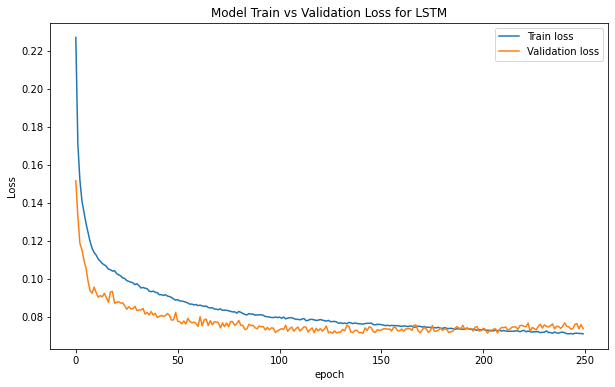

In [12]:
plot_loss(history1,'LSTM')

In [13]:
#Generate predictions
train_pred = model1.predict(train_X)
#evaluation = model.evaluate(x=X_test, y=y_test, verbose=1)
test_pred = model1.predict(test_X)
predictions = test_pred

In [14]:
train_pred.shape

(1303, 12, 24)

In [24]:
# To make a dataframe of original and predicted value:
lstm_df=[]
for i in range (0, len(predictions)):
  lstm_df.append((predictions[i][0][step_output-1]))
final_df = pd.DataFrame((test_y[:,0]))
final_df.rename(columns = {0:'original_value'}, inplace = True)
final_df['predicted_value'] = lstm_df

In [25]:
# To calculate the percentage difference between actual and predicted value:
final_df['total_difference'] = (final_df['predicted_value'] - final_df['original_value']).abs()
final_df['percentage_difference'] = ((final_df['total_difference'])/(final_df['original_value']))*100

In [26]:
import math
from sklearn.metrics import mean_squared_error
#testset = math.sqrt(mean_squared_error(final_df['original_value'], final_df['predicted_value']))
testset = math.sqrt(mean_squared_error(final_df['original_value'], final_df['predicted_value']))
print("The RMSE prediction value on testset: ",testset)

The RMSE prediction value on testset:  0.10171726604219043


In [27]:
# To make complete df:
y = [y[0] for y in test_y]
df_r = hourly_data.reset_index()
days = df_r['Date_time'].values[-len(y):]
df = pd.DataFrame(days,columns = ['Date_time'])
result = pd.concat([df, final_df], axis=1, join='inner')
result.shape

(261, 28)

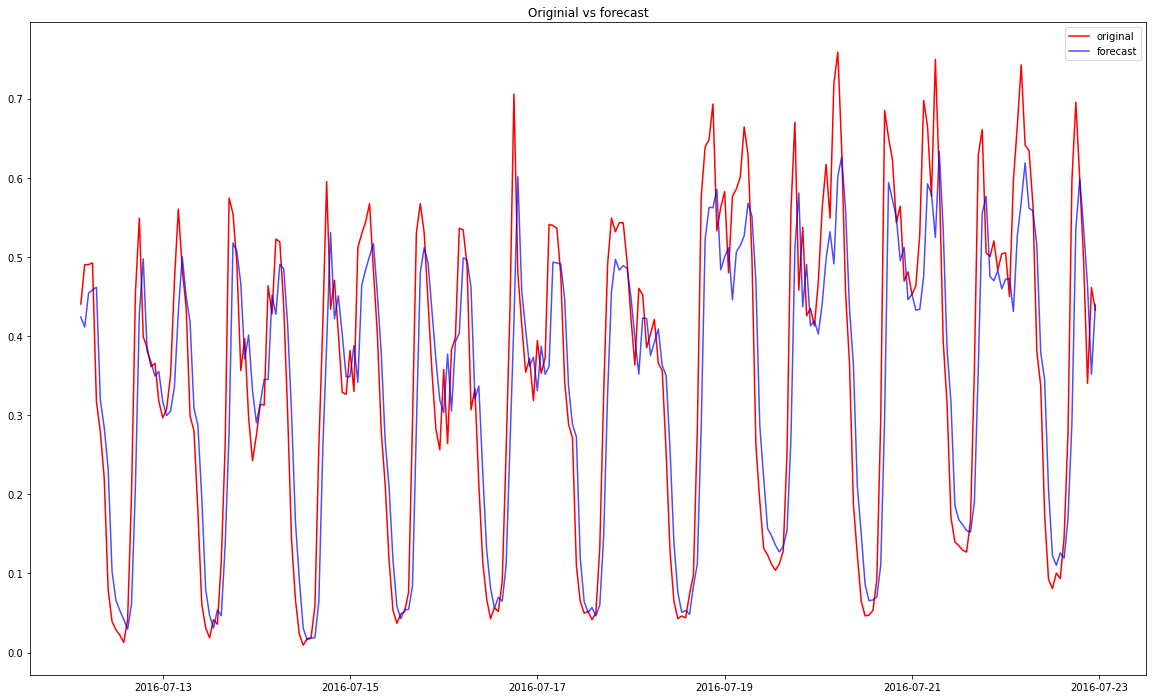

In [28]:
# Plotting original and predicted graph:
plt.figure(figsize=(20, 12))
plt.plot(result.Date_time, result.original_value, color='red', label='original')
plt.plot(result.Date_time, result.predicted_value, color='blue', label='forecast', alpha=0.7)
plt.title('Originial vs forecast')
plt.legend()
plt.show()

In [29]:
from google.colab import files

# e.g. save pandas output as csv
result.to_csv('DMA_468_MLSTM_modified.csv')

# or any other file as usual
# with open('example.csv', 'w') as f:
#   f.write('your strings here')

files.download('DMA_468_MLSTM_modified.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>